In [393]:
# imports
import matplotlib.pyplot as plt
import cv2
import numpy as np
import secrets
from typing import List
import os 
import csv
import sys

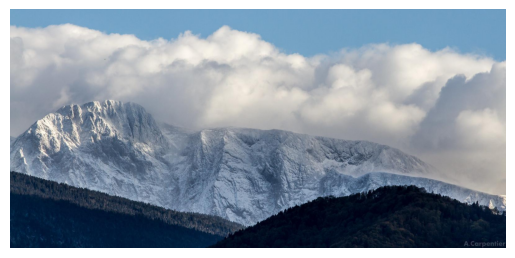

In [394]:
# global vars
bits = 8

# reading and showing image for clarity/testing
img_path = "img/landscape.jpg"
image = plt.imread(img_path)

plt.imshow(image)
plt.axis("off")
plt.show()

In [395]:
#self.image -> cv2.imread(img_path) where img_path = "img/landscape.png"
class bitPlanes(object): 
    def __init__(self, image: np.ndarray):
        self.image = image

    def showImg(self, img: np.ndarray) -> np.ndarray:
        """helper code to show image"""
        if img.any() == None:
            print("Failed to open image try again.")
            return 1
         
        plt.imshow(self.greyScale(img), cmap="gray")
        plt.axis("off")
        plt.title("Original Greyscale Image:")
        plt.show()
        return 0

    def greyScale(self, img) -> np.ndarray:
        if img.any() == None: 
            print(f"Error: could not read image")
            return 
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #test for showing grayimg
        #self.showImg(gray_img)

        return gray_img
    
    def imgShape(self, img: np.ndarray) -> set:
        return (img.shape[0], img.shape[1])
    
    def bitPlaneSlices(self) -> np.ndarray:
        """read the image
        check for proper reading
        initalize rows and columns to be the shape of the image using .shape 
        initalize a bitplanes array to store the np.ndarray types
        iterate through the bits from 0 to range(8)
        bit_plane = np.zeros()
        use and operation with the bit in the loop to seperate into bitplanes"""
        
        #get grayscaled image with added gaussian noise
        grayImage = self.greyScale(self.image)
        imgWidth = self.imgShape(grayImage)[0]
        imgHeight = self.imgShape(grayImage)[1]

        if grayImage is None:
            print(f"Error: could not open image")
            return None 
        
        bit_planes = np.zeros((bits, imgWidth, imgHeight), dtype=np.uint8)
        
        for bit in range(bits):
            bit_planes[bit] = (grayImage >> bit) & 1

        return bit_planes
    
    def map(self) -> dict:
        """
        returns a dictionary of a flattened version of the bitplanes to use in our encryption scheme in the encryption class below
        """
        
        orderedMap = {}

        slices = self.bitPlaneSlices()

        for i in range(bits):
            orderedMap[i] = slices[i].flatten()

        return orderedMap
    
    def merge(self) -> np.ndarray:
        """merges bitplanes to return image"""
        planes = self.bitPlaneSlices()
        mostSignificantBit = np.zeros_like(planes[7], dtype=np.uint8)

        for plane in planes: 
            original_image = np.bitwise_or(mostSignificantBit, plane)

        return original_image

In [396]:
class Encryption(object):
    __bitPlaneIndiceMap = None

    def __init__(self, bitPlaneIndiceMap: dict):
        # Store the provided bit-plane index map (dictionary of 8 flattened arrays)
        self.__bitPlaneIndiceMap = bitPlaneIndiceMap

    def shuffle(self, bitPlaneList: np.ndarray) -> list:
        """
        Performs a secure version of the Fisher-Yates shuffle algorithm.
        Ensures stronger randomness using Python's `secrets` module.
        """
        seen_randint = set()

        # Choose the first secure index and perform the initial swap
        initalSecureRandInt = secrets.randbelow(len(bitPlaneList))
        seen_randint.add(initalSecureRandInt)
        bitPlaneList[-1], bitPlaneList[initalSecureRandInt] = (
            bitPlaneList[initalSecureRandInt],
            bitPlaneList[-1],
        )

        # Continue shuffling from end to start
        for i in range(len(bitPlaneList) - 1, 0, -1):
            secureRandInt = secrets.randbelow(len(bitPlaneList))

            # Ensure we don't reuse random indices
            while secureRandInt in seen_randint:
                secureRandInt = secrets.randbelow(len(bitPlaneList))

            # Swap the current index with the chosen random index
            bitPlaneList[i], bitPlaneList[secureRandInt] = (
                bitPlaneList[secureRandInt],
                bitPlaneList[i],
            )
            seen_randint.add(secureRandInt)

        return bitPlaneList

    def __randomScramblingAlg(self) -> List:
        """
        Applies the scrambling algorithm to all 8 bit planes using two independently
        generated shuffles (KEY1 and KEY2).
        Returns: scrambled bit planes, KEY1, KEY2
        """
        temp = []

        # Use any one bit-plane to determine the length (all have the same size)
        indiciesList = list(range(len(self.__bitPlaneIndiceMap[7])))

        # Generate two secure random permutations of the indices
        R1 = self.shuffle(indiciesList.copy())
        R2 = self.shuffle(indiciesList.copy())

        # Scramble each bit plane using the same R1 and R2
        for j in range(8):
            list_from_plane = list(self.__bitPlaneIndiceMap[j])  # flatten bit plane

            for i in range(len(indiciesList)):
                # Swap values at the R1 and R2 positions
                list_from_plane[R1[i]], list_from_plane[R2[i]] = (
                    list_from_plane[R2[i]],
                    list_from_plane[R1[i]],
                )

            temp.append(list_from_plane)

        # Return the scrambled bit planes as a NumPy array + the two keys
        scrambledBitPlanes = np.array(temp)
        return [scrambledBitPlanes, R1, R2]

    def saveToFile(self, filename) -> np.ndarray:
        """
        Main access method to run the scramble once and save results to disk.
        - Saves bit planes as a .npy file
        - Saves the two keys as a CSV file
        """
        scrambledBitPlanes, KEY1, KEY2 = self.__randomScramblingAlg()
        
        # Ensure output directory exists
        os.makedirs(f"{filename}", exist_ok=True)

        # Save the scrambled planes to a NumPy file
        np.save(f"{filename}/scrambledBitPlanes.npy", scrambledBitPlanes)

        # Save the keys as comma-separated strings into a CSV
        with open(f"{filename}/keys.csv", mode="w", newline="") as csvfile:
            fieldNames = ["KEY1", "KEY2"]
            writer = csv.DictWriter(csvfile, fieldnames=fieldNames)
            writer.writeheader()
            writer.writerow(
                {"KEY1": ",".join(map(str, KEY1)), "KEY2": ",".join(map(str, KEY2))}
            )
            
        return [scrambledBitPlanes, KEY1, KEY2]

In [397]:
class Decryption(object):
    def __init__(self, scrambledBitPlanes: np.ndarray, KEY1: list, KEY2: list):
        self.scrambledBitPlanes = scrambledBitPlanes
        self.KEY1 = KEY1
        self.KEY2 = KEY2

    def decrypt(self, imgWidth: int, imgHeight: int) -> list:
        decryptedPlanes = []

        # Reverse the shuffle for all 8 bit planes
        for scrambled in self.scrambledBitPlanes:
            img = scrambled.copy()

            for i in reversed(range(len(self.KEY1))):
                img[self.KEY1[i]], img[self.KEY2[i]] = img[self.KEY2[i]], img[self.KEY1[i]]

            img = np.reshape(img, (imgWidth, imgHeight))
            decryptedPlanes.append(img)

        return decryptedPlanes

    def merge(self, imgWidth: int, imgHeight: int) -> np.ndarray:
        planes = self.decrypt(imgWidth, imgHeight)

        # Proper reconstruction using bit weights
        original_image = np.zeros_like(planes[0], dtype=np.uint8)
        for i, plane in enumerate(planes):
            original_image += (plane.astype(np.uint8) << i)

        return original_image

In [398]:
def loadFiles(keysFileName: str, encryptedFileName: str) -> List:
    csv.field_size_limit(sys.maxsize)
    
    encryptedData = np.load(f"encrypted/{encryptedFileName}")
    
    with open(f"encrypted/{keysFileName}", newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        row = next(reader)
        KEY1 = list(map(int, row["KEY1"].split(",")))
        KEY2 = list(map(int, row["KEY2"].split(",")))
    
    return encryptedData, KEY1, KEY2

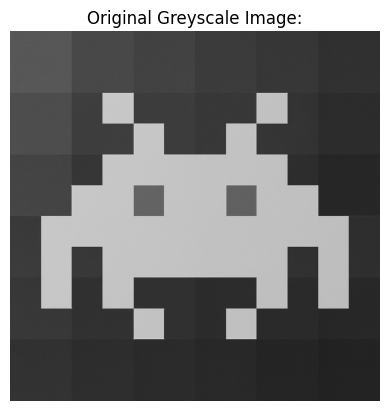

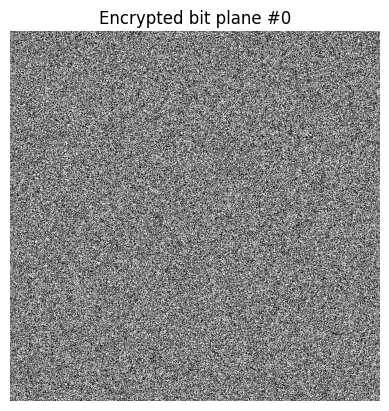

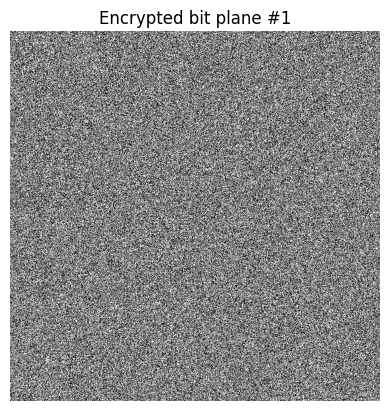

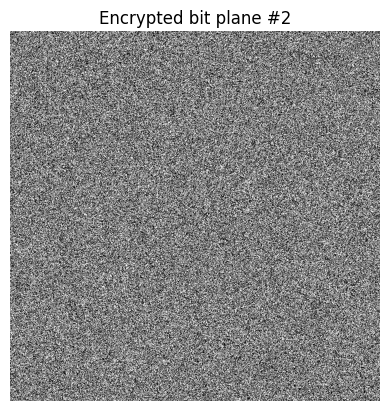

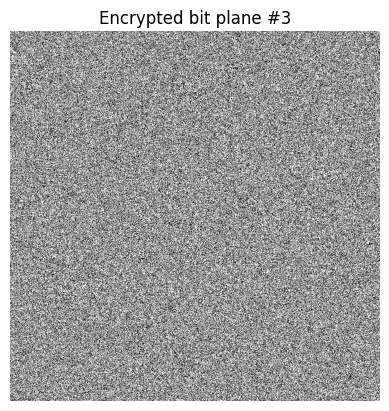

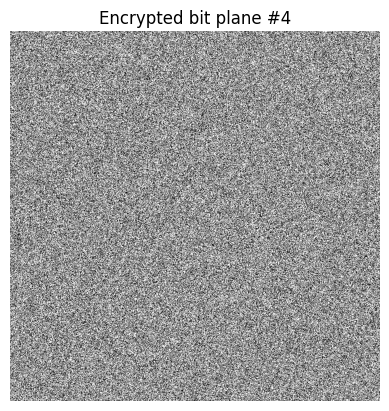

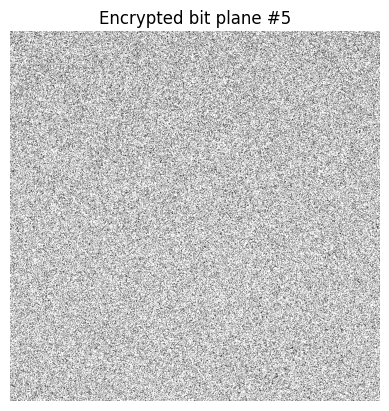

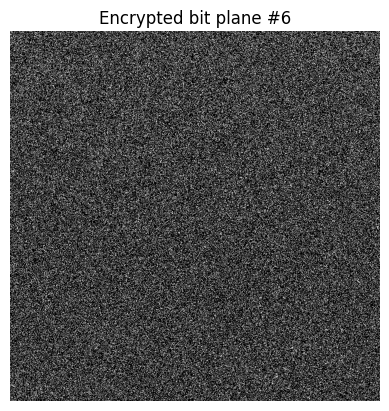

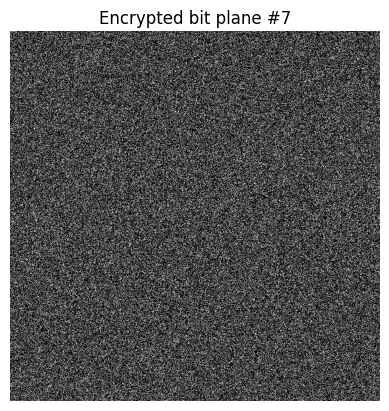

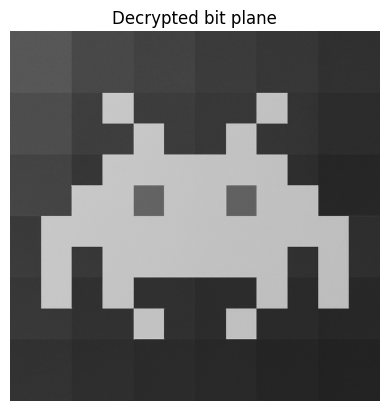

In [399]:
if __name__ == "__main__":
    # Load and process image
    img_path = "img/space_invader.png"
    image = cv2.imread(img_path)
    
    bitPlane = bitPlanes(image)
    
    bitPlane.showImg(image)

    # Bypass the csv limiter for parsing
    csv.field_size_limit(sys.maxsize)

    bitPlane = bitPlanes(image)

    imgWidth = bitPlane.imgShape(image)[0]
    imgHeight = bitPlane.imgShape(image)[1]
        
    encryptedData, KEY1, KEY2 = loadFiles("keys.csv", "scrambledBitPlanes.npy")
    
    for index, img in enumerate(encryptedData):
        img = np.reshape(img, (imgWidth, imgHeight))
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"Encrypted bit plane #{index}")
        plt.show()

    # Decrypt
    decryption = Decryption(encryptedData, KEY1, KEY2)
    decrypted_image = decryption.merge(imgWidth, imgHeight)

    # Display
    plt.imshow(decrypted_image, cmap="gray")
    plt.title("Decrypted bit plane")
    plt.axis("off")
    plt.show()